In [70]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [71]:
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp

        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [72]:
def lstm(model_type,X_train,yuan_X_train):
    if model_type == 1:
        # single-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu',
                    input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))
        yuan_model = Sequential()
        yuan_model.add(LSTM(units=50, activation='relu',
                    input_shape=(yuan_X_train.shape[1], 4)))
        yuan_model.add(Dense(units=4))
    if model_type == 2:
        # multi-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(1))

        yuan_model = Sequential()
        yuan_model.add(LSTM(units=50, activation='relu', return_sequences=True,
                    input_shape=(yuan_X_train.shape[1], 4)))
        yuan_model.add(LSTM(units=50, activation='relu'))
        yuan_model.add(Dense(4))
    if model_type == 3:
        # BiLSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'),
                                input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

        yuan_model = Sequential()
        yuan_model.add(Bidirectional(LSTM(50, activation='relu'),
                                    input_shape=(yuan_X_train.shape[1], 4)))
        yuan_model.add(Dense(4))

    return model,yuan_model

In [73]:
def evaluation_metric(y_test,y_hat):
    MSE = metrics.mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(y_test,y_hat)
    R2 = metrics.r2_score(y_test,y_hat)
    print('MSE: %.5f' % MSE)
    print('RMSE: %.5f' % RMSE)
    print('MAE: %.5f' % MAE)
    print('R2: %.5f' % R2)

In [74]:
# GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
# ====================================
#      model type：
#            1. single-layer LSTM
#            2. multi-layer LSTM
#            3. bidirectional LSTM
# ====================================
model_type = 3

In [75]:
yuan_data = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\TCS.csv")  
yuan_data.index = pd.to_datetime(yuan_data['Date'], format='%Y-%m-%d') 
yuan_data = yuan_data.loc[:, ['Open', 'High', 'Low', 'Close']]

In [76]:
data = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\ARIMA_residuals1.csv")
data.index = pd.to_datetime(data['Date'])
data = data.drop('Date', axis=1)
# data = pd.merge(data, yuan_data, on='trade_date') 

In [77]:
Lt = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\ARIMA.csv")
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

In [78]:
sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

print(pd.DataFrame(training_set_scaled))

print(type(training_set_scaled))

             0
0     0.580370
1     0.587601
2     0.565151
3     0.580263
4     0.591282
...        ...
3494  0.532841
3495  0.670505
3496  0.636835
3497  0.526560
3498  0.222918

[3499 rows x 1 columns]
<class 'numpy.ndarray'>


In [79]:
X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 4)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 4)

In [80]:
model, yuan_model = lstm(model_type,X_train,yuan_X_train)
print(model.summary())
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='mse')
yuan_model.compile(optimizer=adam, loss='mse')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
history = model.fit(X_train, y_train,batch_size=32,epochs=n_epochs,validation_data=(X_test, y_test),validation_freq=1)
yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,batch_size=32,epochs=n_epochs,validation_data=(yuan_X_test, yuan_y_test),validation_freq=1)

Epoch 1/50
110/110 [==============================] - 2s 8ms/step - loss: 0.0102 - val_loss: 0.0361
Epoch 2/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0344
Epoch 3/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0343
Epoch 4/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0353
Epoch 5/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0350
Epoch 6/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0352
Epoch 7/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0356
Epoch 8/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0372
Epoch 9/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0368
Epoch 10/50
110/110 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0372

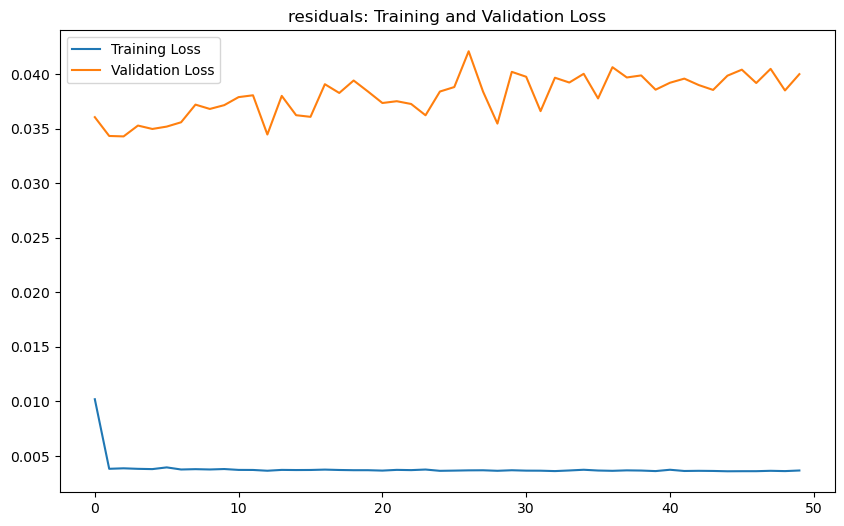

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

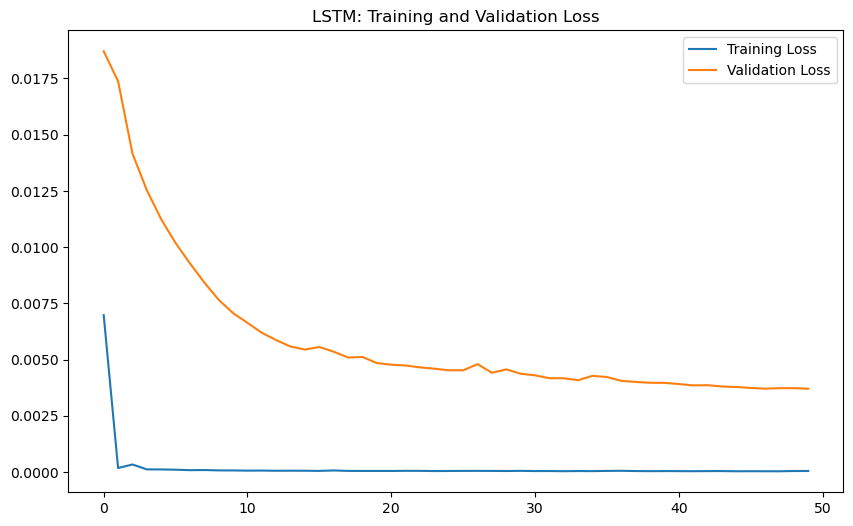

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

In [84]:
yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_predicted_stock_price_list
}

6/6 [==============================] - 0s 2ms/step


In [85]:
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['Date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'Date': yuan_data.index[idx+10:],
    'Close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['Date'], drop=True)

In [86]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

6/6 [==============================] - 0s 3ms/step


In [87]:
predicted_stock_price1 = {
    'Date': data.index[idx+10:],
    'Close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

In [88]:
predicted_stock_price1 = predicted_stock_price1.set_index(['Date'], drop=True)

In [89]:
real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('Date')['Close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['Date']) 
finalpredicted_stock_price = finalpredicted_stock_price.drop(['Date'], axis=1)

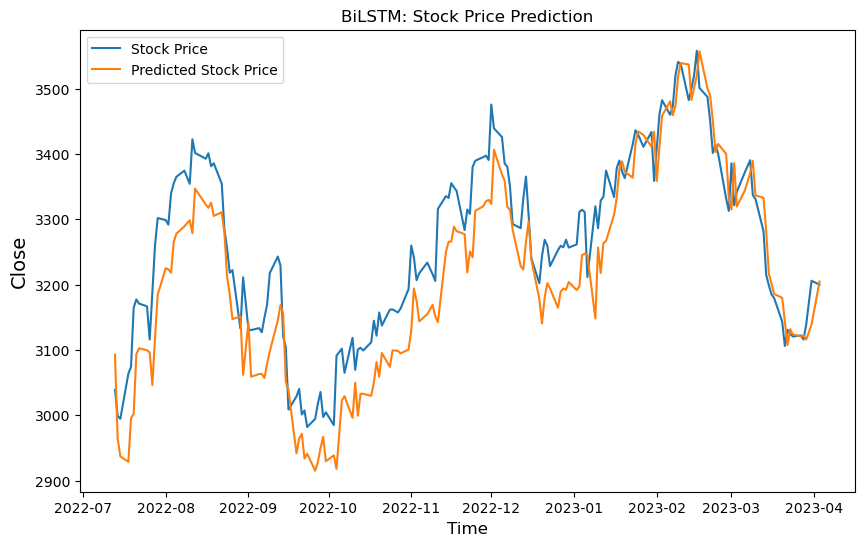

In [90]:
plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2022-07-13':, 'Close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['Close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()


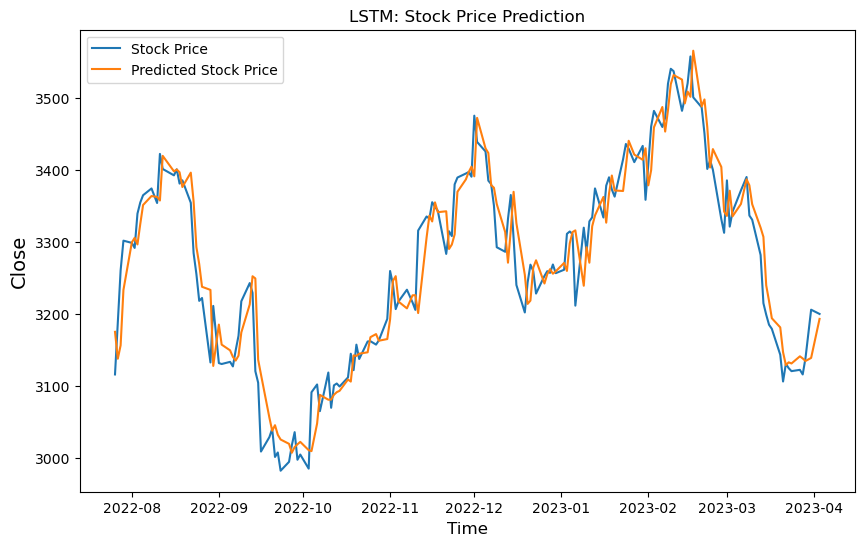

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['Close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['Close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [92]:
yhat = yuan_data.loc['2022-07-13':, 'Close']
evaluation_metric(finalpredicted_stock_price['Close'],yhat)

MSE: 5074.52326
RMSE: 71.23569
MAE: 60.02905
R2: 0.78490
